# Let’s Help Santa!

Go to “Uber Movement” website and download data of Monthly Aggregate (all days), 2017 Quarter 4, for San Francisco area1. The dataset contains pairwise traveling time statistics between most pairs of points in San Francisco area. Points on the map are represented by unique IDs. To understand the correspondence between map IDs and areas, download Geo Boundaries file from the same website2. This file contains latitudes and longitudes of the corners of the polygons circumscribing each area. In addition, it contains one street address inside each area, referred to as DISPLAY NAME. To be specific, if an area is represented by a polygon with 5 corners, then you have a 5 × 2 matrix of the latitudes and longitudes, each row of which represents latitude and longitude of one corner.

## Question 6:
Report the number of nodes and edges in G.

In [280]:
import numpy as np
import pandas as pd
import json as js
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
%matplotlib inline

data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv', header=0, sep=',')
json_data = pd.read_json("san_francisco_censustracts.json")

In [281]:
# Get node attribute and add node to graph
node_dic = {}
G = nx.Graph()

for node_info in json_data['features']:
    node_id = int(node_info['properties']['MOVEMENT_ID'])
    if node_id in node_dic:
        print('WTf')
    else:
        dis_name = node_info['properties']['DISPLAY_NAME']
        location = np.mean(np.array(node_info['geometry']['coordinates'][0][0]), axis=0)
        node_dic[node_id] = {'DISPLAY_NAME':dis_name, 'Location':location}
        G.add_node(node_id, name=dis_name, Location=location)

In [282]:
data_row = data.shape[0]
data_col = data.shape[1]
edge_dic = {}

# Get edges and avg of multi-edges
for idx in range(data_row):
    if int(data['month'][idx]) != 12:
        continue
    edge_w = float(data['mean_travel_time'][idx])
    sourceid = int(data['sourceid'][idx])
    dstid = int(data['dstid'][idx])
    if (sourceid, dstid) in edge_dic:
        edge_dic[(sourceid, dstid)][0] += edge_w
        edge_dic[(sourceid, dstid)][1] += 1
    elif (dstid, sourceid) in edge_dic:
        edge_dic[(dstid, sourceid)][0] += edge_w
        edge_dic[(dstid, sourceid)][1] += 1
    else:
        edge_dic[(sourceid, dstid)] = [edge_w, 1]

In [283]:
# add edges to the graph
for key, item in edge_dic.items():
    w = item[0]/item[1]
    G.add_edge(key[0], key[1], weight=w)
    
Gcc = max(nx.connected_component_subgraphs(G), key=len)

In [284]:
print("Number of nodes are:", nx.number_of_nodes(Gcc))
print("Number of edges are:", nx.number_of_edges(Gcc))

Number of nodes are: 1898
Number of edges are: 321703


## Question 7:
Build a minimum spanning tree (MST) of graph G. Report the street addresses of the two endpoints of a few edges. Are the results intuitive?

In [285]:
MST = nx.minimum_spanning_tree(Gcc)

In [286]:
for point in sorted(nx.edges(MST)):
    print(node_dic[point[0]]["DISPLAY_NAME"], "----", node_dic[point[1]]["DISPLAY_NAME"])

400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 1500 Oxford Street, Palm Park, Redwood City
400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 100 Fifth Avenue, South Fair Oaks, Redwood City
18300 Sutter Boulevard, Morgan Hill ---- 17300 Lotus Way, Morgan Hill
18300 Sutter Boulevard, Morgan Hill ---- 1900 Alpet Drive, Morgan Hill
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 8900 Cal Center Drive, Sacramento
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 9500 River Rose Way, Premier Garden, Sacramento
100 Carlsbad Circle, Vacaville ---- Interstate 505, Vacaville
100 Carlsbad Circle, Vacaville ---- 500 Morningstar Way, Vacaville
Unnamed Road, Vacaville ---- 400 Bowline Drive, Vacaville
Unnamed Road, Vacaville ---- 100 Monte Verde Drive, Vacaville
700 Carlsbad Court, Petaluma ---- 0 Maria Drive, Petaluma
700 Carlsbad Court, Petaluma ---- 200 Ely Road North, Petaluma
700 Carlsbad Court, Petaluma ---- 900 Telford Lane, Petaluma
500 Hyde Street, Tenderloin, San

1000 66th Avenue, Coliseum, Oakland ---- 1100 77th Avenue, Fitchburg, Oakland
2000 Francisco Street, North Berkeley, Berkeley ---- 2000 Rose Street, North Berkeley, Berkeley
2500 Parker Street, Elmwood, Berkeley ---- 2400 Channing Way, Southside, Berkeley
2500 Parker Street, Elmwood, Berkeley ---- 2300 Oregon Street, South Berkeley, Berkeley
1400 168th Avenue, San Leandro ---- 15500 Tracy Street, San Lorenzo
1400 168th Avenue, San Leandro ---- 600 Elgin Street, San Lorenzo
2600 Oliver Drive, Glen Eden, Hayward ---- 24700 Mohr Drive, Mount Eden, Hayward
2600 Oliver Drive, Glen Eden, Hayward ---- San Francisco Bay Trail, Hayward
2600 El Charro Road, Pleasanton ---- 1000 Serpentine Lane, Pleasanton
400 Oxford Way, Belmont ---- 3000 Los Prados Street, East San Mateo, San Mateo
400 Oxford Way, Belmont ---- 200 Shorebird Circle, Redwood Shores, Redwood City
1500 Marcia Avenue, Central San Jose, San Jose ---- 800 Kingfisher Drive, South San Jose, San Jose
14200 Candler Avenue, Alum Rock, San 

## Question 8:
Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

In [287]:
import random

node_scale = max(node_dic.keys())
sample_num = 0
triangle_num = 0
used = set()

while sample_num < 1000:
    sourceid = random.randint(1, node_scale)
    dstid = random.randint(1, node_scale)
    midid = random.randint(1, node_scale)
    if sourceid != midid != dstid and (sourceid, dstid) in edge_dic \
    and (sourceid, midid) in edge_dic and (midid, dstid) in edge_dic \
    and (sourceid, midid, dstid) not in used:
        used.add((sourceid, midid, dstid))
        sample_num += 1
        dij = edge_dic[(sourceid, midid)][0]/edge_dic[(sourceid, midid)][1]
        djk = edge_dic[(midid, dstid)][0]/edge_dic[(midid, dstid)][1]
        dik = edge_dic[(sourceid, dstid)][0]/edge_dic[(sourceid, dstid)][1]
        if dij+djk > dik:
            triangle_num += 1

print(triangle_num/sample_num*100, "% of triangles in the graph satisfy the triangle inequality", sep='')

97.6% of triangles in the graph satisfy the triangle inequality


## Question 9:
Find an upper bound on the empirical performance of the approximate algorithm:
$$\rho = \frac{\text{Approximate TSP Cost}}{\text{Optimal TSP Cost}}$$

In [288]:
# Create multi-graph
Multi_G = nx.MultiDiGraph()
Multi_G.add_nodes_from(MST)
path = []

for edge in MST.edges:
    w = MST.edges[edge]['weight']
    Multi_G.add_edge(edge[0], edge[1], weight=w)
    Multi_G.add_edge(edge[1], edge[0], weight=w)
    
# Find Euler-circle
Euler_circle = nx.eulerian_circuit(Multi_G)

# Calculate the length of the tour from Euler-circle
# (There are multiple Euler-circles, here we only choose the first circle)
travel_length = 0
idx = 0

for edge in Euler_circle:
    if idx == 0:
        start = edge[0]
    if edge[1] == start:
        print(edge[0])
        dst = edge[0]
        path.append(dst)
        print('---------------------------------------')
        break
    travel_length += Multi_G.edges[edge[0], edge[1], 0]['weight']
    path.append(edge[0])
    print(edge[0], "->", end=' ')
    idx += 1
    
print("Approximate TSP cost is:", travel_length)

2 -> 1727 -> 530 -> 1734 -> 2456 -> 531 -> 2378 -> 2607 -> 2240 -> 1852 -> 2240 -> 2607 -> 2378 -> 531 -> 1725 -> 1726 -> 2251 -> 1736 -> 1737 -> 1363 -> 1737 -> 1736 -> 2251 -> 1726 -> 1725 -> 531 -> 2456 -> 1734 -> 530 -> 394 -> 1721 -> 1724 -> 2513 -> 2229 -> 2513 -> 232 -> 2155 -> 347 -> 1851 -> 347 -> 1359 -> 881 -> 562 -> 125 -> 1850 -> 1849 -> 1848 -> 1849 -> 1850 -> 125 -> 562 -> 86 -> 2305 -> 741 -> 345 -> 1833 -> 920 -> 1832 -> 1838 -> 1337 -> 1357 -> 1825 -> 2222 -> 2223 -> 1853 -> 744 -> 2490 -> 744 -> 1869 -> 1361 -> 1358 -> 742 -> 1358 -> 1361 -> 1869 -> 744 -> 1853 -> 2223 -> 2222 -> 1333 -> 1948 -> 1333 -> 829 -> 2656 -> 1949 -> 1937 -> 557 -> 1936 -> 2221 -> 1936 -> 725 -> 1947 -> 725 -> 1936 -> 557 -> 1311 -> 1329 -> 824 -> 1935 -> 1933 -> 1935 -> 1331 -> 1934 -> 2376 -> 1934 -> 2232 -> 1934 -> 1331 -> 1935 -> 1222 -> 2173 -> 724 -> 1330 -> 390 -> 1871 -> 1381 -> 831 -> 745 -> 831 -> 1381 -> 170 -> 1381 -> 1871 -> 563 -> 1872 -> 563 -> 1871 -> 390 -> 1330 -> 724 -> 21

 2201 -> 2612 -> 627 -> 1547 -> 100 -> 2209 -> 479 -> 954 -> 57 -> 102 -> 55 -> 102 -> 1651 -> 1655 -> 1047 -> 417 -> 628 -> 31 -> 1658 -> 109 -> 1054 -> 1659 -> 1054 -> 109 -> 1522 -> 1523 -> 1070 -> 1523 -> 1524 -> 2224 -> 462 -> 596 -> 2401 -> 1515 -> 431 -> 1515 -> 2401 -> 596 -> 97 -> 596 -> 462 -> 1071 -> 1525 -> 887 -> 1525 -> 1514 -> 1072 -> 96 -> 1074 -> 597 -> 1074 -> 96 -> 1072 -> 1514 -> 2620 -> 463 -> 2620 -> 2349 -> 1516 -> 1518 -> 283 -> 1081 -> 283 -> 456 -> 58 -> 456 -> 283 -> 1518 -> 464 -> 1512 -> 2212 -> 194 -> 1030 -> 886 -> 284 -> 886 -> 2213 -> 457 -> 808 -> 1498 -> 808 -> 285 -> 1080 -> 1504 -> 1080 -> 285 -> 808 -> 457 -> 2597 -> 181 -> 1045 -> 611 -> 1056 -> 611 -> 1045 -> 181 -> 612 -> 2346 -> 1527 -> 2346 -> 612 -> 181 -> 809 -> 322 -> 1046 -> 1053 -> 446 -> 949 -> 446 -> 1053 -> 591 -> 2215 -> 99 -> 2215 -> 1536 -> 287 -> 1536 -> 810 -> 1537 -> 2437 -> 2218 -> 1539 -> 2342 -> 2519 -> 2216 -> 2214 -> 2421 -> 2225 -> 2421 -> 2214 -> 1530 -> 1058 -> 1529 -> 24

1824 -> 1336 -> 738 -> 558 -> 1825 -> 1357 -> 37 -> 1357 -> 1337 -> 1838 -> 561 -> 1834 -> 561 -> 1838 -> 308 -> 2377 -> 308 -> 1847 -> 2658 -> 346 -> 830 -> 2536 -> 830 -> 346 -> 2658 -> 1847 -> 308 -> 1838 -> 1832 -> 560 -> 740 -> 559 -> 1830 -> 559 -> 740 -> 560 -> 1832 -> 920 -> 1833 -> 304 -> 2169 -> 904 -> 237 -> 1831 -> 237 -> 904 -> 2169 -> 554 -> 306 -> 2525 -> 1302 -> 555 -> 2170 -> 555 -> 1181 -> 2526 -> 1303 -> 2526 -> 1181 -> 555 -> 1302 -> 2525 -> 306 -> 1339 -> 306 -> 554 -> 2169 -> 304 -> 303 -> 304 -> 1833 -> 155 -> 1833 -> 345 -> 741 -> 87 -> 927 -> 87 -> 741 -> 2305 -> 86 -> 562 -> 881 -> 1359 -> 127 -> 743 -> 1360 -> 743 -> 127 -> 1359 -> 347 -> 2155 -> 232 -> 2513 -> 1724 -> 1721 -> 1473 -> 1721 -> 394 -> 1472 -> 1211 -> 1472 -> 394 -> 530 -> 339 -> 530 -> 1727
---------------------------------------
Approximate TSP cost is: 440276.24000000046


In [289]:
# Get opt_length
opt_length = 0

for edge in MST.edges:
    opt_length += MST.edges[edge]['weight']
    
print("Optimal TSP cost is:", opt_length)

Optimal TSP cost is: 289315.6749999996


In [290]:
print("rho is:", travel_length/opt_length)

rho is: 1.5217849499512983


## Question 10:
Plot the trajectory that Santa has to travel!

Text(0.5, 1.0, 'The trajectory Santa has to travel')

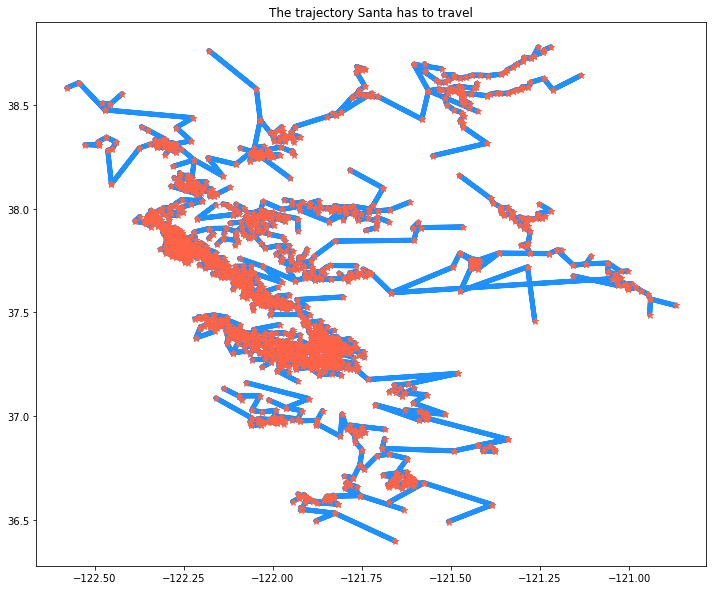

In [291]:
X = []
Y = []

for node in path:
    X.append(node_dic[node]['Location'][0])
    Y.append(node_dic[node]['Location'][1])

# plot the trajectory
plt.figure(figsize=(12, 10))
plt.plot(X, Y, linewidth=5, color='dodgerblue')
plt.plot(X, Y, '*', markersize=7, color='tomato')
plt.title('The trajectory Santa has to travel')

## Question 11:
Plot the road mesh that you obtain and explain the result. Create a graph G∆ whose nodes are different locations and its edges are produced by triangulation.

In [292]:
from scipy.spatial import Delaunay

vertices = nx.nodes(Gcc)
mean_coordinates = np.zeros((len(json_data['features']), 2))
for i in range(len(json_data['features'])):
    mean_coordinates[i, :] = np.mean(json_data['features'][i]['geometry']['coordinates'][0][0], axis=0)
    
mean_coordinates_gcc = mean_coordinates[[x-1 for x in vertices], :]
triangulation = Delaunay(mean_coordinates_gcc)

Text(0.5, 1.0, 'Road Mesh in SF Bay Area')

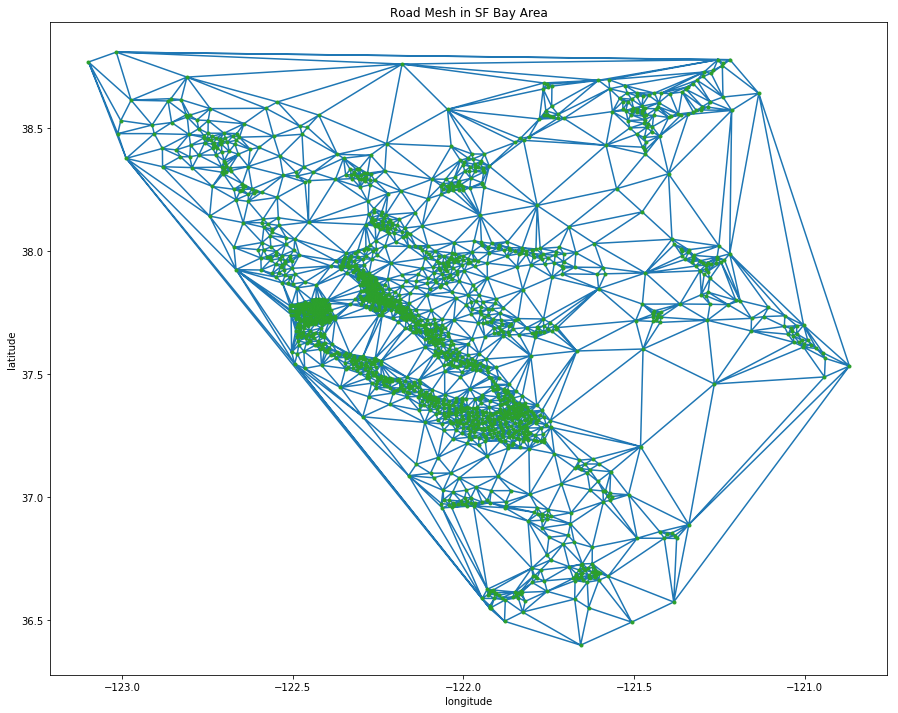

In [351]:
plt.figure(figsize=(15,12))
plt.triplot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], triangulation.simplices)
plt.plot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], '.')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh in SF Bay Area')

In [294]:
G_delta = nx.Graph()

used_nodes = triangulation.simplices
edges_delta = set()
for row in range(used_nodes.shape[0]):
    for index in range(3):   
        node1 = list(vertices)[used_nodes[row][index]]
        node2 = list(vertices)[used_nodes[row][(index + 1) % 3]]
        if (node1, node2) not in edges_delta and (node2, node1) not in edges_delta:
            edges_delta.add((node1, node2))
            G_delta.add_edge(node1, node2)
#         if (node1, node2) in edge_dic or (node2, node1) in edge_dic and \
#         (node1, node2) not in edges_delta and (node2, node1) not in edges_delta:
#             edges_delta.add((node1, node2))
#             if (node1, node2) in edge_dic:
#                 weight = edge_dic[(node1, node2)][0] / edge_dic[(node1, node2)][1]
#                 G_delta.add_edge(node1, node2, weight=weight)
#             else:
#                 weight = edge_dic[(node2, node1)][0] / edge_dic[(node2, node1)][1]
#                 G_delta.add_edge(node2, node1, weight=weight)
                
print("Number of nodes in G_delta:", nx.number_of_nodes(G_delta))
print("Number of edges in G_delta:", nx.number_of_edges(G_delta))

Number of nodes in G_delta: 1898
Number of edges in G_delta: 5680


## Question 12:
Using simple math, calculate the traffic flow for each road in terms of cars/hour. Report your derivation.
Consider the following assumptions:

- Each degree of latitude and longitude ≈ 69 miles
- Carlength≈5m=0.003mile
- Cars maintain a safety distance of 2 seconds to the next car
- Each road has 2 lanes in each direction

Assuming no traffic jam, consider the calculated traffic flow as the max capacity of each road.

In [338]:
miles_per_degree = 69
car_len = 0.003
safe_time = 2/3600
lanes = 2
traffic_flow = {}
fake_flow = []

edges_delta = nx.edges(G_delta)

for edge in list(edges_delta):
    u = edge[0]
    v = edge[1]
    mean_time = 1e8
    if (u, v) in edge_dic:
        mean_time = edge_dic[(u, v)][0] / edge_dic[(u, v)][1]
    elif (v, u) in edge_dic:
        mean_time = edge_dic[(v, u)][0] / edge_dic[(v, u)][1]
        
    miles = np.sqrt(np.square(
                    abs(node_dic[u]['Location'][0] - node_dic[v]['Location'][0]) * miles_per_degree) +
                    np.square(
                    abs(node_dic[u]['Location'][1] - node_dic[v]['Location'][1]) * miles_per_degree
                )
           )
    
    car_speed = miles / (mean_time / 3600)
    safety_dist = car_speed * safe_time
    car_flow = car_speed / (car_len + safety_dist) * lanes
    G_delta.add_edge(u, v, capacity = car_flow)
    traffic_flow[(u, v)] = car_flow
    if mean_time == 1e8:
        fake_flow.append(car_flow)

fake_flow_threshold = max(fake_flow)
print("The fake flow are all under", fake_flow_threshold)
print("Number of fake flows are:", len(fake_flow))

The fake flow are all under 3.502789189460015
Number of fake flows are: 392


## Question 13:
Calculate the maximum number of cars that can commute per hour from Stanford to UCSC. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match what you see on your road map?

In [302]:
Stanford_ID = 0
UCSC_ID = 0

for key in node_dic:
    if node_dic[key]['DISPLAY_NAME'] == '100 Campus Drive, Stanford':
        Stanford_ID = key
        print("Stanford node id:", Stanford_ID)
    if node_dic[key]['DISPLAY_NAME'] == '700 Meder Street, Santa Cruz':
        UCSC_ID = key
        print("UCSC node id:", UCSC_ID)

UCSC node id: 1968
Stanford node id: 2607


In [307]:
flow_value, flow_dict = nx.maximum_flow(G_delta, UCSC_ID, Stanford_ID)
print("Max flow is:", flow_value)

Max flow is: 14866.477294089982


In [299]:
edge_disjoint_paths = nx.edge_disjoint_paths(G_delta, Stanford_ID, UCSC_ID)
count = 0
for i in edge_disjoint_paths:
    count += 1
    print(i)
    
print("The number of edge-disjoint paths are:", count)

[2607, 1363, 1869, 744, 2242, 1980, 1968]
[2607, 1736, 1762, 1210, 2458, 1955, 1980, 1431, 1968]
[2607, 1726, 1736, 1737, 744, 938, 1989, 1431, 1424, 1968]
[2607, 1725, 1733, 1209, 1762, 1763, 1980, 2241, 1968]
[2607, 2240, 1363, 1737, 1763, 1955, 1171, 2241, 748, 1968]
The number of edge-disjoint paths are: 5


In [304]:
Stanford_loc = node_dic[Stanford_ID]['Location']
print("Stanford location:", Stanford_loc[0], Stanford_loc[1])

UCSC_loc = node_dic[UCSC_ID]['Location']
print("UCSC location:", UCSC_loc[0], UCSC_loc[1])

Stanford location: -122.1759822222222 37.42968588888888
UCSC location: -122.06456181081083 36.97416881081081


Text(0.5, 1.0, 'Zoomed in road map at Stanford')

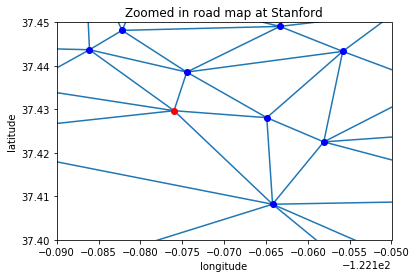

In [305]:
plt.plot(Stanford_loc[0], Stanford_loc[1], 'o', color='red')
for node in node_dic:
    if node != Stanford_ID:
        plt.plot(node_dic[node]['Location'][0], node_dic[node]['Location'][1], 'o', color='blue')
plt.triplot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], triangulation.simplices)
plt.xlim(-122.19, -122.15)
plt.ylim(37.4, 37.45)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in road map at Stanford')

Text(0.5, 1.0, 'Zoomed in road map at UCSC')

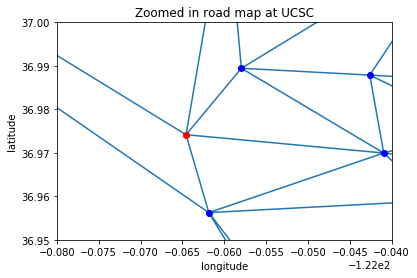

In [306]:
plt.plot(UCSC_loc[0], UCSC_loc[1], 'o', color='red')
for node in node_dic:
    if node != UCSC_ID:
        plt.plot(node_dic[node]['Location'][0], node_dic[node]['Location'][1], 'o', color='blue')
plt.triplot(mean_coordinates_gcc[:,0], mean_coordinates_gcc[:,1], triangulation.simplices)
plt.xlim(-122.08, -122.04)
plt.ylim(36.95, 37.00)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in road map at UCSC')

## Question 14:
Plot $\tilde{G}_∆$ on actual coordinates. Are real bridges preserved?

Hint: You can consider the following coordinates:
- Golden Gate Bridge: [[-122.475, 37.806], [-122.479, 37.83]]
- Richmond, San Rafael Bridge: [[-122.501, 37.956], [-122.387, 37.93]]
- San Mateo Bridge: [[-122.273, 37.563], [-122.122, 37.627]]
- Dambarton Bridge: [[-122.142, 37.486], [-122.067, 37.54]]
- San Francisco - Oakland Bay Bridge: [[-122.388, 37.788], [-122.302, 37.825]]

In [335]:
G_tilde = nx.Graph()
G_tilde.add_nodes_from(G_delta)

fake_flow_threshold = 5

for edge in G_delta.edges:
    capacity = G_delta.edges[edge]['capacity']
    if capacity <= fake_flow_threshold:
        continue
    G_tilde.add_edge(edge[0], edge[1], capacity=capacity)

In [365]:
GGB = np.array([[-122.475, 37.806], [-122.479, 37.83]])
RSRB = np.array([[-122.501, 37.956], [-122.387, 37.93]])
SMB = np.array([[-122.273, 37.563], [-122.122, 37.627]])
DB = np.array([[-122.142, 37.486], [-122.067, 37.54]])
SFOBB = np.array([[-122.388, 37.788], [-122.302, 37.825]])
bridges = [GGB, RSRB, SMB, DB, SFOBB]
bridge_on_map = []

def get_nearest_node(target, node_list):
    distances = []
    for i in range(len(node_list)):
        x = node_dic[node_list[i]]['Location'][0]
        y = node_dic[node_list[i]]['Location'][1]  
        dis = (target[0]-x)**2+(target[1]-y)**2
        distances.append(dis)
    return node_list[np.argsort(distances)[0]]

for i in range(len(bridges)):
    road = bridges[i]
    near_nodes1 = []
    near_nodes2 = []
    for node in node_dic:
        x = node_dic[node]['Location'][0]
        y = node_dic[node]['Location'][1]    
        if round(road[0,0], 1) == round(x,1) and round(road[0,1], 1) == round(y,1):
            near_nodes1.append(node)
        if round(road[1,0], 1) == round(x,1) and round(road[1,1], 1) == round(y,1):
            near_nodes2.append(node)
    node1 = get_nearest_node(road[0, :], near_nodes1)
    node2 = get_nearest_node(road[1, :], near_nodes2)
    bridge_on_map.append((node1, node2))

Text(0.5, 1.0, 'Graph with fake traffic flow trimmed')

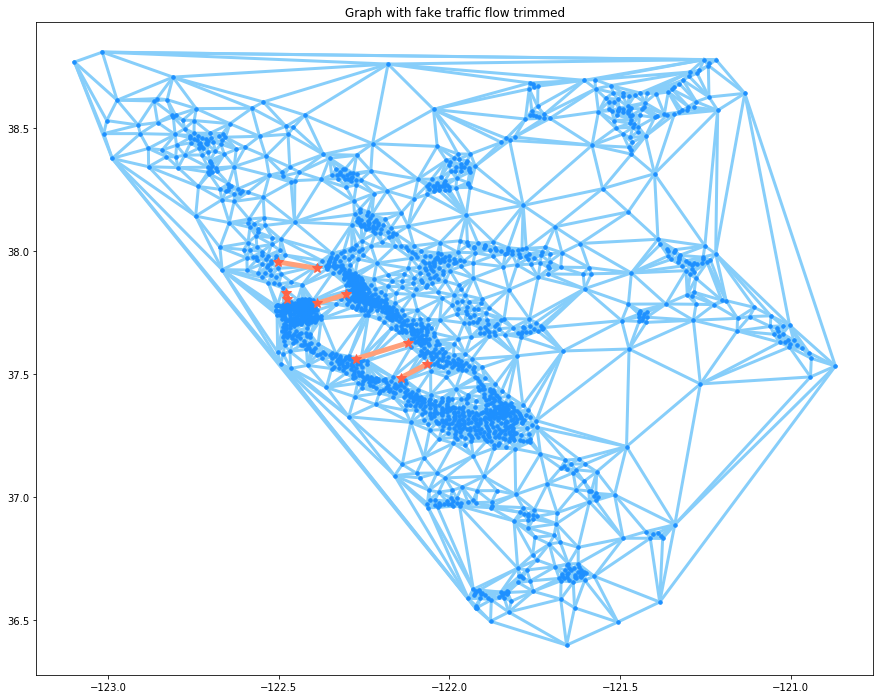

In [377]:
plt.figure(figsize=(15, 12))
    
for edge in G_delta.edges:
    x = [node_dic[edge[0]]['Location'][0], node_dic[edge[1]]['Location'][0]]
    y = [node_dic[edge[0]]['Location'][1], node_dic[edge[1]]['Location'][1]]
    plt.plot(x, y, linewidth=3, color='lightskyblue')
    
for node in G_delta.nodes:
    plt.plot(node_dic[node]['Location'][0], node_dic[node]['Location'][1], '.', markersize=7, color='dodgerblue')
    
for road in bridges:
    x = [road[0,0], road[1,0]]
    y = [road[0,1], road[1,1]]
#     x = [node_dic[road[0]]['Location'][0], node_dic[road[1]]['Location'][0]]
#     y = [node_dic[road[0]]['Location'][1], node_dic[road[1]]['Location'][1]]
    plt.plot(x, y, linewidth=5, color='lightsalmon')
    plt.plot(x, y, '*', markersize=10, color='tomato')
plt.title('Graph with fake traffic flow trimmed')

## Question 15:
Now, repeat question 13 for $\tilde{G}_∆$ and report the results. Do you see any significant changes?

In [369]:
flow_value, flow_dict = nx.maximum_flow(G_tilde, UCSC_ID, Stanford_ID)
print("Max flow is:", flow_value)

Max flow is: 14866.477294089984


In [370]:
edge_disjoint_paths = nx.edge_disjoint_paths(G_tilde, Stanford_ID, UCSC_ID)
count = 0
for i in edge_disjoint_paths:
    count += 1
    print(i)
    
print("The number of edge-disjoint paths are:", count)

[2607, 1363, 1361, 1849, 1848, 1853, 1357, 2223, 2222, 931, 829, 2656, 725, 1936, 2596, 1934, 1989, 1431, 1980, 1968]
[2607, 1736, 1363, 1869, 1853, 2223, 2490, 1948, 2656, 1947, 725, 2221, 1934, 2232, 1432, 239, 1424, 748, 1968]
[2607, 1726, 1736, 1737, 1869, 744, 1947, 2221, 938, 1989, 1432, 1431, 1968]
[2607, 2378, 743, 1852, 1358, 1850, 1849, 1853, 744, 1948, 1947, 938, 2242, 2528, 1980, 2241, 1968]
[2607, 2240, 1363, 1737, 744, 938, 2528, 1981, 1431, 1424, 1968]
The number of edge-disjoint paths are: 5


Text(0.5, 1.0, 'Zoomed in road map at Stanford')

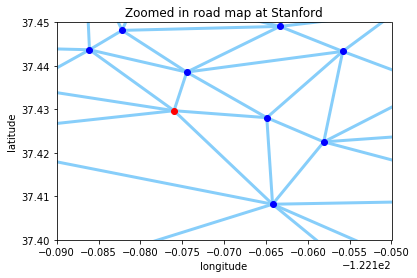

In [373]:
for edge in G_delta.edges:
    x = [node_dic[edge[0]]['Location'][0], node_dic[edge[1]]['Location'][0]]
    y = [node_dic[edge[0]]['Location'][1], node_dic[edge[1]]['Location'][1]]
    plt.plot(x, y, linewidth=3, color='lightskyblue')
    
plt.plot(Stanford_loc[0], Stanford_loc[1], 'o', color='red')
for node in node_dic:
    if node != Stanford_ID:
        plt.plot(node_dic[node]['Location'][0], node_dic[node]['Location'][1], 'o', color='blue')
plt.xlim(-122.19, -122.15)
plt.ylim(37.4, 37.45)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in road map at Stanford')

Text(0.5, 1.0, 'Zoomed in road map at UCSC')

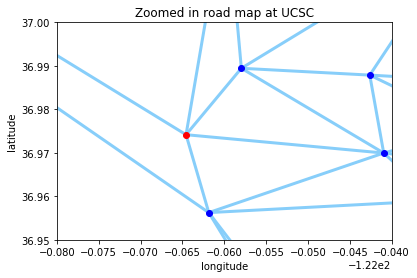

In [374]:
for edge in G_delta.edges:
    x = [node_dic[edge[0]]['Location'][0], node_dic[edge[1]]['Location'][0]]
    y = [node_dic[edge[0]]['Location'][1], node_dic[edge[1]]['Location'][1]]
    plt.plot(x, y, linewidth=3, color='lightskyblue')

plt.plot(UCSC_loc[0], UCSC_loc[1], 'o', color='red')
for node in node_dic:
    if node != UCSC_ID:
        plt.plot(node_dic[node]['Location'][0], node_dic[node]['Location'][1], 'o', color='blue')
plt.xlim(-122.08, -122.04)
plt.ylim(36.95, 37.00)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in road map at UCSC')